<div dir="rtl" style="text-align: right;">
    
### **تمرین سری چهارم هوش مصنوعی**
### **بخش اول: UCI HAR**
### **محمدمهدی تویسرکانی**

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

<div dir="rtl" style="text-align: right;">
    
### **1- آماده‌سازی داده‌ها**

In [3]:
def load_dataset(folder):
    X = pd.read_csv(f'{folder}/X_{folder}.txt', sep=r'\s+', header=None)
    y = pd.read_csv(f'{folder}/y_{folder}.txt', sep=r'\s+', header=None)
    subject = pd.read_csv(f'{folder}/subject_{folder}.txt', sep=r'\s+', header=None)
    return X.values, y.values.ravel(), subject.values.ravel()

X_train, y_train, _ = load_dataset('train')
X_test, y_test, _ = load_dataset('test')

In [3]:
X_all = np.vstack((X_train, X_test))
y_all = np.hstack((y_train, y_test))

scaler = StandardScaler()
X_all_norm = scaler.fit_transform(X_all)

In [4]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_all_norm, y_all, test_size=0.15, random_state=42, stratify=y_all)

print("Train shape:", X_train_norm.shape)
print("Test shape:", X_test_norm.shape)

Train shape: (8754, 561)
Test shape: (1545, 561)


<div dir="rtl" style="text-align: right;">
    
### **2- طراحی شبکه MLP**

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim=561, num_classes=6):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

<div dir="rtl" style="text-align: right;">
    
### **3- طراحی شبکه CNN**

In [6]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=6):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64 * 140, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

<div dir="rtl" style="text-align: right;">
    
### **4- آموزش و 5- ارزیابی**

In [7]:
def prepare_dataloader(X, y, batch_size=64, cnn=False):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    if cnn:
        X_tensor = X_tensor.view(X_tensor.shape[0], 1, -1)
    y_tensor = torch.tensor(y - 1, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = prepare_dataloader(X_train_norm, y_train_norm, cnn=False)
test_loader = prepare_dataloader(X_test_norm, y_test_norm, cnn=False)

def train_model(model, train_loader, test_loader, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_loss, test_loss, train_acc, test_acc = [], [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss, correct = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()

        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / len(train_loader.dataset))

        model.eval()
        total, correct = 0, 0
        loss_eval = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss_eval += criterion(outputs, y_batch).item()
                correct += (outputs.argmax(1) == y_batch).sum().item()
        test_loss.append(loss_eval / len(test_loader))
        test_acc.append(correct / len(test_loader.dataset))

        print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Test Acc: {test_acc[-1]:.4f}")

    return train_loss, test_loss, train_acc, test_acc, model

In [8]:
def plot_metrics(train_loss, test_loss, train_acc, test_acc, title='MLP'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss, label="Test Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(test_acc, label="Test Acc")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    plt.show()

def plot_confusion_matrix(model, test_loader, title='MLP'):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

Epoch 1: Train Acc: 0.8143, Test Acc: 0.9463
Epoch 2: Train Acc: 0.9486, Test Acc: 0.9689
Epoch 3: Train Acc: 0.9644, Test Acc: 0.9715
Epoch 4: Train Acc: 0.9726, Test Acc: 0.9715
Epoch 5: Train Acc: 0.9725, Test Acc: 0.9709
Epoch 6: Train Acc: 0.9767, Test Acc: 0.9735
Epoch 7: Train Acc: 0.9812, Test Acc: 0.9748
Epoch 8: Train Acc: 0.9804, Test Acc: 0.9767
Epoch 9: Train Acc: 0.9767, Test Acc: 0.9806
Epoch 10: Train Acc: 0.9810, Test Acc: 0.9819
Epoch 11: Train Acc: 0.9844, Test Acc: 0.9819
Epoch 12: Train Acc: 0.9872, Test Acc: 0.9819
Epoch 13: Train Acc: 0.9866, Test Acc: 0.9832
Epoch 14: Train Acc: 0.9891, Test Acc: 0.9773
Epoch 15: Train Acc: 0.9865, Test Acc: 0.9722
Epoch 16: Train Acc: 0.9873, Test Acc: 0.9819
Epoch 17: Train Acc: 0.9871, Test Acc: 0.9819
Epoch 18: Train Acc: 0.9873, Test Acc: 0.9819
Epoch 19: Train Acc: 0.9899, Test Acc: 0.9832
Epoch 20: Train Acc: 0.9910, Test Acc: 0.9812


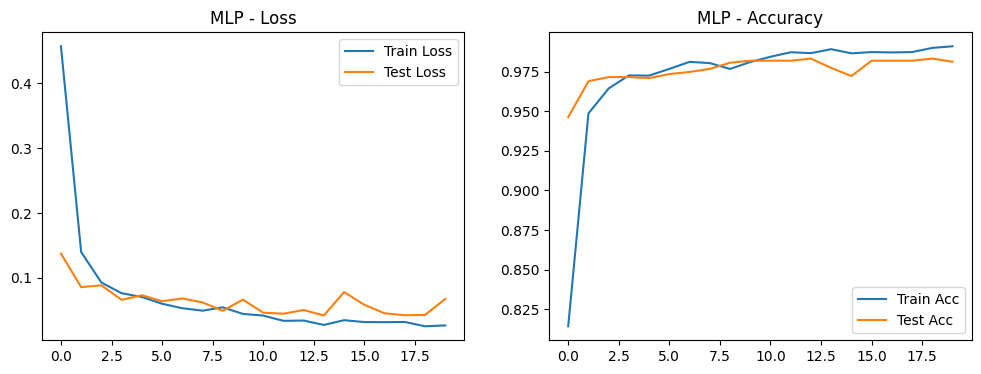

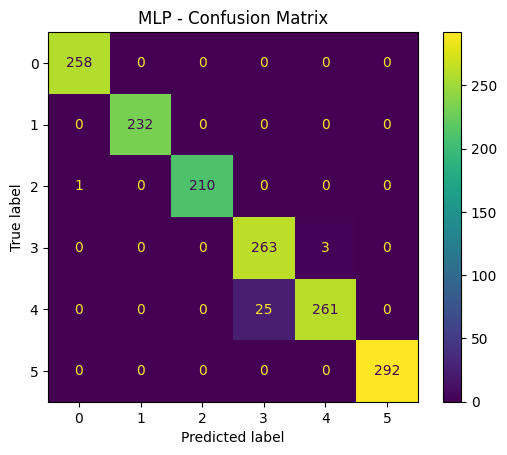

In [9]:
mlp = MLP()
tr_loss, ts_loss, tr_acc, ts_acc, mlp_model = train_model(mlp, train_loader, test_loader)
plot_metrics(tr_loss, ts_loss, tr_acc, ts_acc, title='MLP')
plot_confusion_matrix(mlp_model, test_loader, title='MLP')

In [10]:
train_loader_cnn = prepare_dataloader(X_train_norm, y_train_norm, cnn=True)
test_loader_cnn = prepare_dataloader(X_test_norm, y_test_norm, cnn=True)

Epoch 1: Train Acc: 0.8867, Test Acc: 0.9702
Epoch 2: Train Acc: 0.9617, Test Acc: 0.9735
Epoch 3: Train Acc: 0.9762, Test Acc: 0.9715
Epoch 4: Train Acc: 0.9746, Test Acc: 0.9631
Epoch 5: Train Acc: 0.9821, Test Acc: 0.9806
Epoch 6: Train Acc: 0.9837, Test Acc: 0.9845
Epoch 7: Train Acc: 0.9865, Test Acc: 0.9845
Epoch 8: Train Acc: 0.9870, Test Acc: 0.9806
Epoch 9: Train Acc: 0.9894, Test Acc: 0.9799
Epoch 10: Train Acc: 0.9889, Test Acc: 0.9864
Epoch 11: Train Acc: 0.9926, Test Acc: 0.9871
Epoch 12: Train Acc: 0.9919, Test Acc: 0.9877
Epoch 13: Train Acc: 0.9923, Test Acc: 0.9761
Epoch 14: Train Acc: 0.9913, Test Acc: 0.9864
Epoch 15: Train Acc: 0.9949, Test Acc: 0.9864
Epoch 16: Train Acc: 0.9899, Test Acc: 0.9864
Epoch 17: Train Acc: 0.9898, Test Acc: 0.9650
Epoch 18: Train Acc: 0.9880, Test Acc: 0.9838
Epoch 19: Train Acc: 0.9936, Test Acc: 0.9871
Epoch 20: Train Acc: 0.9974, Test Acc: 0.9851


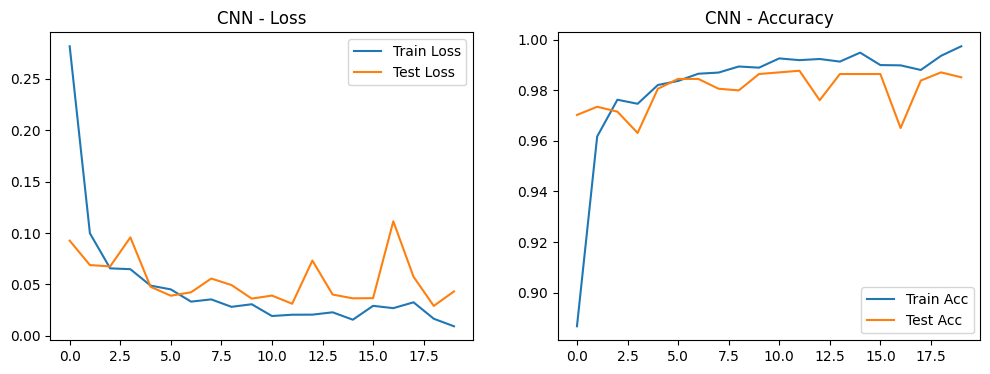

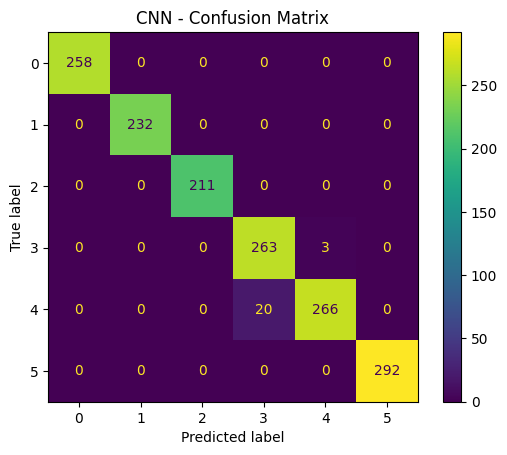

In [11]:
cnn = CNN()
train_loss_cnn, test_loss_cnn, train_acc_cnn, test_acc_cnn, cnn_model = train_model(
    cnn, train_loader_cnn, test_loader_cnn, epochs=20)
plot_metrics(train_loss_cnn, test_loss_cnn, train_acc_cnn, test_acc_cnn, title='CNN')
plot_confusion_matrix(cnn_model, test_loader_cnn, title='CNN')